# A machine learning approach for the classification of cardiac arrhythmia
The aim of this project is to determine the type of arrhythmia from the ECG recordings.

Eleonora Detić

In [19]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from scipy import stats

### Data loading

In [11]:
df = pd.read_csv('data_arrhythmia.csv', delimiter=';')
df.dataframeName = 'data_arrhythmia.csv'

In [43]:
#data_fake = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/arrhythmia/arrhythmia.data', header=None)
with open("arrhythmia.names") as f:
    print(f.read())

1. Title: Cardiac Arrhythmia Database

2. Sources:
   (a) Original owners od Database:
       -- 1. H. Altay Guvenir, PhD., 
             Bilkent University,
             Department of Computer Engineering and Information Science,
             06533 Ankara, Turkey
             Phone: +90 (312) 266 4133
             Email: guvenir@cs.bilkent.edu.tr

       -- 2. Burak Acar, M.S.,
             Bilkent University, 
             EE Eng. Dept. 
             06533 Ankara, Turkey
             Email: buraka@ee.bilkent.edu.tr

       -- 2. Haldun Muderrisoglu, M.D., Ph.D., 
             Baskent University, 
             School of Medicine
             Ankara, Turkey

   (b) Donor: H. Altay Guvenir
              Bilkent University,
              Department of Computer Engineering and Information Science,
              06533 Ankara, Turkey
              Phone: +90 (312) 266 4133
              Email: guvenir@cs.bilkent.edu.tr

   (c) Date: January, 1998

3. Past Usage:
   1. H. Altay Guvenir, Bura

### Data survey

In [13]:
df.shape

(452, 280)

In [44]:
df.head()

,age,sex,height,weight,qrs_duration,p-r_interval,q-t_interval,t_interval,p_interval,qrs,...,KY,KZ,LA,LB,LC,LD,LE,LF,LG,diagnosis
0,75,0,190,80,91,193,371,174,121,-16,...,0.0,9.0,-0.9,0.0,0,0.9,2.9,23.3,49.4,8
1,56,1,165,64,81,174,401,149,39,25,...,0.0,8.5,0.0,0.0,0,0.2,2.1,20.4,38.8,6
2,54,0,172,95,138,163,386,185,102,96,...,0.0,9.5,-2.4,0.0,0,0.3,3.4,12.3,49.0,10
3,55,0,175,94,100,202,380,179,143,28,...,0.0,12.2,-2.2,0.0,0,0.4,2.6,34.6,61.6,1
4,75,0,190,80,88,181,360,177,103,-16,...,0.0,13.1,-3.6,0.0,0,-0.1,3.9,25.4,62.8,7


In our data set, we have 452 patients and 279 features for each patient. Last column is interpreted as a number of heart arrhythmia claster. According to documentation, missing attribute values are distinguished with '?' so we will replace them with "NaN".

In [57]:
df = df.replace('?', np.NaN)
df.isna().sum().nlargest(10)

J               376
P                22
T                 8
QRST              1
heart_rate        1
age               0
sex               0
height            0
weight            0
qrs_duration      0
dtype: int64

As we can see, in column 'J' we have a lof of missing values, more than 80%, so we will drop that column.

In [61]:
df.drop(["J"], axis=1, inplace=True)

0      NaN
1      NaN
2       23
3      NaN
4      NaN
      ... 
447    NaN
448    NaN
449     84
450    103
451    NaN
Name: J, Length: 452, dtype: object

As for the other columns, since these variables are continuous, the first idea could be to hope for a normal distribution and then try to preserve the variability of the data by randomly simulate the missing values. <br> For this purpose, we perform well know **Kolmogorov–Smirnov** test.

In [86]:
print(stats.kstest(df[df['P'].notnull()]['P'].astype(int), 'norm'))
print(stats.kstest(df[df['T'].notnull()]['T'].astype(int), 'norm'))
print(stats.kstest(df[df['QRST'].notnull()]['QRST'].astype(int), 'norm'))
print(stats.kstest(df[df['heart_rate'].notnull()]['heart_rate'].astype(int), 'norm'))

KstestResult(statistic=0.9255811086972653, pvalue=0.0)
KstestResult(statistic=0.847749201067469, pvalue=0.0)
KstestResult(statistic=0.8168319201501881, pvalue=0.0)
KstestResult(statistic=1.0, pvalue=0.0)


This assumption was obviously too ambitious. For all columns, the p value turned out to be very small and the test statistics very large. <br> So our conclusion is that at each standard level of significance, we reject the null hypothesis, that is, that our data **do not follow** a normal distribution. <br>
The next idea is standard. We will replace the missing values with the mean of each column.

In [94]:
imp= SimpleImputer(missing_values=np.NaN, strategy='mean')
idf=pd.DataFrame(imp.fit_transform(df))
idf.columns=df.columns
idf.index=df.index
df = idf

Finally, there are no more missing values in our data.

#### Descriptive statistics

KstestResult(statistic=0.995983935741692, pvalue=0.0)
KstestResult(statistic=0.9887978852196014, pvalue=0.0)


age                                                   
     count       mean        std  min   25%   50%   75%   max
sex                                                          
0    203.0  47.546798  16.519761  0.0  37.5  47.0  59.0  80.0
1    249.0  45.594378  16.404173  1.0  34.0  46.0  58.0  83.0

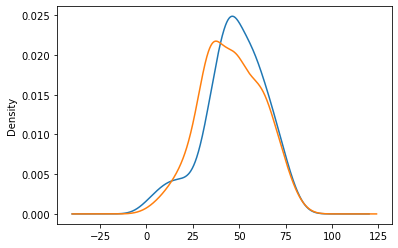

In [41]:
print(stats.kstest(df.loc[df['sex'] == 1]['age'], 'norm'))
print(stats.kstest(df.loc[df['sex'] == 0]['age'], 'norm'))
df.groupby('sex').age.plot(kind='kde') #vizualni prikaz
df[["sex", "age"]].groupby("sex").describe() #deskriptivna statistika

The above results show the distribution graph and descriptive statistics, for both women and men. We conducted ks test and concluded 

#### Data transformation

In [39]:
print(stats.kstest(df.loc[df['sex'] == 1]['age'], 'norm'))

KstestResult(statistic=0.995983935741692, pvalue=0.0)


#### Data cleaning

In [40]:
print(stats.kstest(df.loc[df['sex'] == 0]['age'], 'norm'))

KstestResult(statistic=0.9887978852196014, pvalue=0.0)


#### Data validation

#### Data augmentation

#### Feature enginerring

## Missing Values

In [33]:
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_mean.fit(data)
SimpleImputer()
data = imp_mean.transform(data)
data = pd.DataFrame(data)


In [34]:
X = data.loc[:,0:278]
y = data.loc[:,279]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [38]:
pca = PCA(.99)
pca.fit(X_train)

PCA(n_components=0.99)

In [39]:
kk = pca.transform(X_train)